# An exploratory analysis of readmission data

Readmission of patients into hospitals can place an unwanted burden on healthcare and its already limited resources, as hospital staff would now be required to attend to additional patients beyond the inpatients already under their care. Often, these readmitted patients are those whose conditions have worsened enough so as to require a visit to the hospital.

This notebook explores anonymised patient data as well as their readmission status and identifies tangible next steps and questions one could raise with a client (in this case, a healthcare provider) in order to build a predictive model that could predict the risk of readmission within the next 30 days.

An enhanced understanding of which patients are at higher risk of being readmitted, as well as what factors contribute to their increased risk, can allow healthcare providers to allocate the right amount of resources earlier to high-risk patients and reduce their overall expenditure in the long-term.

_"A stitch in time saves nine" - Thomas Fuller, 1732_

## Overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_excel('readmission_data_example.xlsx')
df.drop(['weight'], axis=1, inplace=True) # almost all are "?" (unknown)
df.head()
print(df.shape)

(101766, 26)


In [10]:
visit_count = df['patient_nbr'].value_counts()
visit_count.head(10)

88785891.0    40
43140906.0    28
1660293.0     23
88227540.0    23
23199021.0    23
23643405.0    22
84428613.0    22
92709351.0    21
88789707.0    20
29903877.0    20
Name: patient_nbr, dtype: int64

Revisits:  47021


(array([1.59e+04, 7.34e+02, 9.50e+01, 2.10e+01, 1.50e+01, 6.00e+00,
        1.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([ 2. ,  5.8,  9.6, 13.4, 17.2, 21. , 24.8, 28.6, 32.4, 36.2, 40. ]),
 <BarContainer object of 10 artists>)

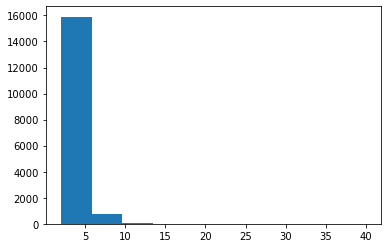

In [21]:
print("Revisits: ", visit_count[visit_count > 1].values.sum())
plt.hist(visit_count[visit_count > 1].values)

In [46]:
unique_patients = df.drop_duplicates(subset=['patient_nbr'])
unique_patients['gender'].replace({"Unknown": "Female"}, inplace=True) # only 3 unknowns, just do mode imputation for now
unique_patients.head()

C:\Users\nicho\AppData\Local\Temp\ipykernel_21956\446908343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_patients['gender'].replace({"Unknown": "Female"}, inplace=True) # only 3 unknowns, just do mode imputation for now


,encounter_id,patient_nbr,ethnicity,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,insulin,medication_change,diabetesMed,readmitted
0,2278392.0,8222157.0,European,Female,[0-10),6.0,25.0,1.0,1.0,Pediatrics-Endocrinology,...,250.83,?,?,1.0,None,None,No,No,No,NO
1,149190.0,55629189.0,European,Female,[10-20),1.0,1.0,7.0,3.0,?,...,276.0,250.01,255.0,9.0,None,None,Up,Ch,Yes,>30
2,64410.0,86047875.0,Māori,Female,[20-30),1.0,1.0,7.0,2.0,?,...,648.0,250.0,V27,6.0,None,None,No,No,Yes,NO
3,500364.0,82442376.0,European,Male,[30-40),1.0,1.0,7.0,2.0,?,...,8.0,250.43,403.0,7.0,None,None,Up,Ch,Yes,NO
4,16680.0,42519267.0,European,Male,[40-50),1.0,1.0,7.0,1.0,?,...,197.0,157.0,250.0,5.0,None,None,Steady,Ch,Yes,NO


In [47]:
# readmitted_unique_patients = unique_patients[unique_patients['patient_nbr'].isin(vc[vc > 1].index)]

readmitted_unique_patients = df[(df['readmitted'] == '>30') | (df['readmitted'] == '<30')]
readmitted_unique_patients.drop_duplicates(subset=['patient_nbr'], inplace=True)
readmitted_unique_patients.head()

C:\Users\nicho\AppData\Local\Temp\ipykernel_21956\3344088517.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readmitted_unique_patients.drop_duplicates(subset=['patient_nbr'], inplace=True)


,encounter_id,patient_nbr,ethnicity,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,insulin,medication_change,diabetesMed,readmitted
1,149190.0,55629189.0,European,Female,[10-20),1.0,1.0,7.0,3.0,?,...,276.0,250.01,255.0,9.0,None,None,Up,Ch,Yes,>30
5,35754.0,82637451.0,European,Male,[50-60),2.0,1.0,2.0,3.0,?,...,414.0,411.0,250.0,9.0,None,None,Steady,No,Yes,>30
7,63768.0,114882984.0,European,Male,[70-80),1.0,1.0,7.0,5.0,?,...,428.0,492.0,250.0,8.0,None,None,No,No,Yes,>30
10,28236.0,89869032.0,Māori,Female,[40-50),1.0,1.0,7.0,9.0,?,...,250.7,403.0,996.0,9.0,None,None,Steady,No,Yes,>30
11,36900.0,77391171.0,Māori,Male,[60-70),2.0,1.0,4.0,7.0,?,...,157.0,288.0,197.0,7.0,None,None,Steady,Ch,Yes,<30


In [48]:
# nonreadmitted_unique_patients = unique_patients[~unique_patients['patient_nbr'].isin(vc[vc > 1].index)]

nonreadmitted_unique_patients = df[(df['readmitted'] == 'NO') & (~df['patient_nbr'].isin(readmitted_unique_patients['patient_nbr'].values))] # some patients get readmitted but not after their last visit where readmitted = 'NO'
nonreadmitted_unique_patients.drop_duplicates(subset=['patient_nbr'], inplace=True)
nonreadmitted_unique_patients.head()

C:\Users\nicho\AppData\Local\Temp\ipykernel_21956\114886023.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonreadmitted_unique_patients.drop_duplicates(subset=['patient_nbr'], inplace=True)


,encounter_id,patient_nbr,ethnicity,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,insulin,medication_change,diabetesMed,readmitted
0,2278392.0,8222157.0,European,Female,[0-10),6.0,25.0,1.0,1.0,Pediatrics-Endocrinology,...,250.83,?,?,1.0,None,None,No,No,No,NO
2,64410.0,86047875.0,Māori,Female,[20-30),1.0,1.0,7.0,2.0,?,...,648.0,250.0,V27,6.0,None,None,No,No,Yes,NO
3,500364.0,82442376.0,European,Male,[30-40),1.0,1.0,7.0,2.0,?,...,8.0,250.43,403.0,7.0,None,None,Up,Ch,Yes,NO
4,16680.0,42519267.0,European,Male,[40-50),1.0,1.0,7.0,1.0,?,...,197.0,157.0,250.0,5.0,None,None,Steady,Ch,Yes,NO
6,55842.0,84259809.0,European,Male,[60-70),3.0,1.0,2.0,4.0,?,...,414.0,411.0,V45,7.0,None,None,Steady,Ch,Yes,NO


The dataset consists of 101,766 records of hospital visits made by diabetes patients, of which 47,021 were revisits.

In total, there were 71,518 unique patients, of which 28,784 (40.2%) were readmitted at least once i.e. at least one visit was recorded as <30 or >30, while 42,734 (59.8%) were not readmitted at all i.e. only one visit recorded and recorded as NO.

1. Over what time period was this data collected and from where?

Knowing how long of a time period this data represents, as well as across how many different hospitals this data was aggregated would be particularly useful for further analysis, as hospitals could differ in the level of care provided and there may be seasonal trends in readmissions that could be harnessed for prediction.

If such information is already present within the data itself (for example, encoded within the admission IDs), a data dictionary could help in pre-processing this data to extract the relevant information.

2. Do we only want to reduce 30-day readmissions for patients with diabetes?

While this dataset only contains diabetes data, it may be useful to inquire about data sources from other departments or disease groups that could provide a more holistic view of the patients in this dataset.

## Distributions

The key question trying to be answered here is: are there any observable differences between patients who were readmitted and those who were not?

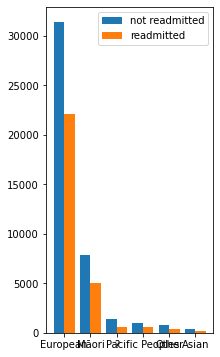

In [49]:
plt.bar(np.arange(6)-0.2, nonreadmitted_unique_patients['ethnicity'].value_counts().values, width=0.4, label='not readmitted')
plt.bar(np.arange(6)+0.2, readmitted_unique_patients['ethnicity'].value_counts().values, width=0.4, label='readmitted')
plt.xticks(np.arange(6), list(nonreadmitted_unique_patients['ethnicity'].value_counts().index))
plt.legend()

In [50]:
age_groups_nonreadmitted = sorted(dict(nonreadmitted_unique_patients['age'].value_counts()).items(), key=lambda x: x[0])
age_groups_readmitted = sorted(dict(readmitted_unique_patients['age'].value_counts()).items(), key=lambda x: x[0])
age_group_counts_nonreadmitted = [age_groups_nonreadmitted[i][1] for i in range(len(age_groups_nonreadmitted))]
age_group_counts_readmitted = [age_groups_readmitted[i][1] for i in range(len(age_groups_readmitted))]

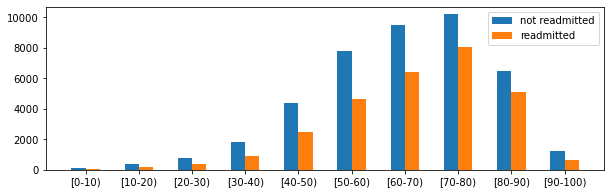

In [51]:
variable = 'age'
plt.rcParams["figure.figsize"] = (10,3)
plt.bar(3*np.arange(nonreadmitted_unique_patients[variable].nunique())-0.4, age_group_counts_nonreadmitted, width=0.8, label='not readmitted')
plt.bar(3*np.arange(nonreadmitted_unique_patients[variable].nunique())+0.4, age_group_counts_readmitted, width=0.8, label='readmitted')
plt.xticks(3*np.arange(nonreadmitted_unique_patients[variable].nunique()), sorted(list(nonreadmitted_unique_patients[variable].value_counts().index)))
plt.legend()

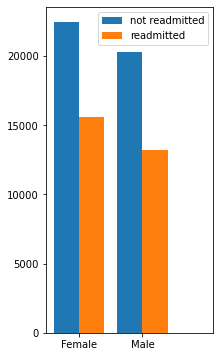

In [55]:
variable = 'gender'
plt.rcParams["figure.figsize"] = (3,6)
plt.bar(np.arange(nonreadmitted_unique_patients[variable].nunique())-0.2, nonreadmitted_unique_patients[variable].value_counts().values, width=0.4, label='not readmitted')
plt.bar(np.arange(readmitted_unique_patients[variable].nunique())+0.2, readmitted_unique_patients[variable].value_counts().values, width=0.4, label='readmitted')
plt.xticks(np.arange(readmitted_unique_patients[variable].nunique()), list(readmitted_unique_patients[variable].value_counts().index))
plt.legend()

In [58]:
summary_stats = pd.DataFrame()
summary_stats = pd.concat([summary_stats, nonreadmitted_unique_patients[['patient_nbr','readmitted']], readmitted_unique_patients[['patient_nbr','readmitted']]], axis=0)
summary_stats['readmitted'].replace({'NO':0, '<30':1, '>30':1}, inplace=True)
summary_stats.sort_values(by='patient_nbr', inplace=True)
for var_to_group in ['num_medications', 'num_lab_procedures', 'num_procedures', 'number_diagnoses']:
    summary_stats[var_to_group] = df[['patient_nbr', var_to_group]].groupby('patient_nbr').sum()[var_to_group].values
summary_stats.head()

,patient_nbr,readmitted,num_medications,num_lab_procedures,num_procedures,number_diagnoses
4267,135.0,1,47.0,108.0,7.0,13.0
5827,378.0,0,11.0,49.0,1.0,3.0
67608,729.0,0,23.0,68.0,2.0,9.0
17494,774.0,0,20.0,46.0,0.0,9.0
2270,927.0,0,5.0,49.0,0.0,3.0


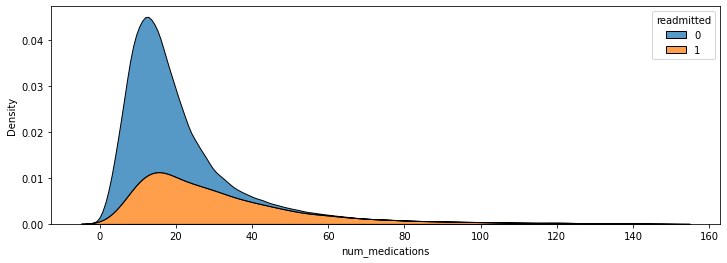

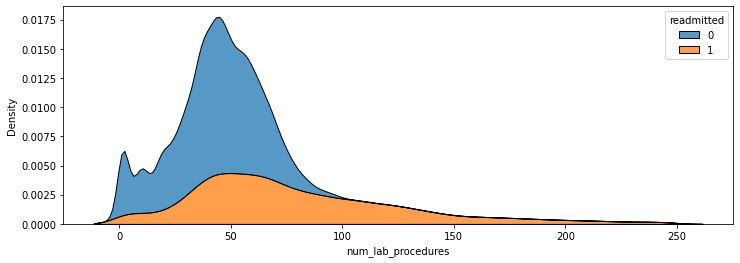

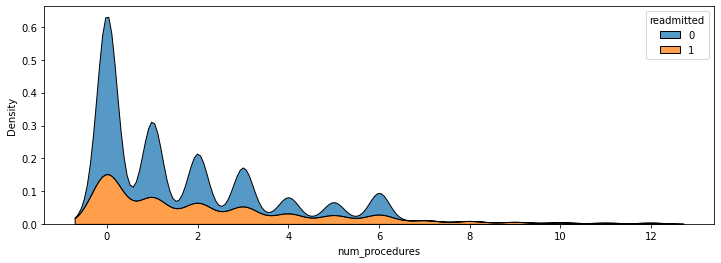

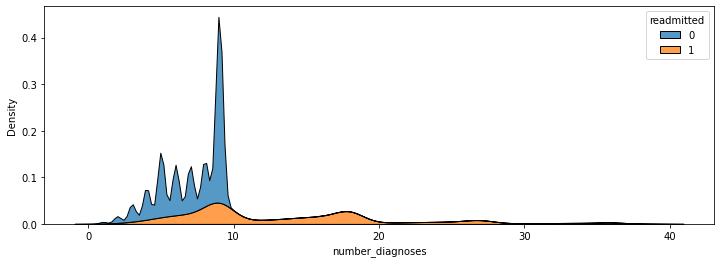

In [24]:
thresholds = {'num_medications':150, 'num_lab_procedures':250, 'num_procedures':13, 'number_diagnoses':40}

for x in thresholds.keys():
    plt.figure(figsize=(12,4))
    temp_stats = summary_stats[summary_stats[x] < thresholds[x]]
    sns.kdeplot(data=temp_stats, x=x, hue='readmitted', multiple='stack')

Similar distributions can be observed across age, ethnicity, and gender for all patients regardless of whether or not they were readmitted.

For the number of medications, procedures, and diagnoses, a long tail was observed for readmitted patients (this is not clearly shown in the KDE plots above), suggesting the presence of possible predictors of readmission rish - further investigation into these variables may be valuable, especially when considering the use of binning or feature scaling during pre-processing.

## Correlations

<AxesSubplot:>

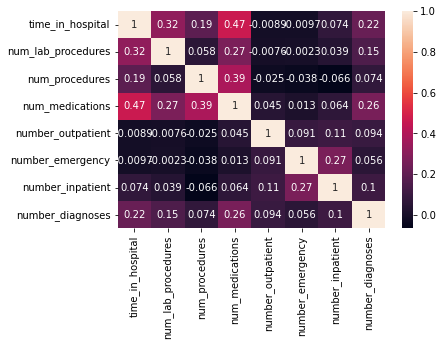

In [131]:
df_numeric = df._get_numeric_data()
df_numeric.drop(['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id'], axis=1, inplace=True)
sns.heatmap(df_numeric.corr(), annot=True)

A simple Pearson correlation shows the number of lab procedures and medications being the most strongly correlated with the amount of time spent in a hospital, as well as the number of procedures and number of medications.

An interesting observation (not shown here) was made where diagnosis codes (represented by the variables diag_1, diag_2, and diag_3) seemed continuous but, upon further external investigation, were found to be discrete. These codes ranged between 100 to 700, and 20-33% of codes in each of the three columns were within a small range of values (20% diag_1 were in 400s, 20% diag_2 were in 600s, 33% diag_3 were in 200s and 400s).

More information about these codes could be useful, as they could be grouped into overarching categories representing, for example, healthy and unhealthy diagnoses. However, if these diagnosis codes are recorded after a patient has been readmitted, this may be a consideration for avoiding data leakage when going on to build a predictive model.

## Data Quality

c:\Users\nicho\miniconda3\envs\361\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Sum of inpatient, outpatient and emergency procedures for nonreadmitted patients')

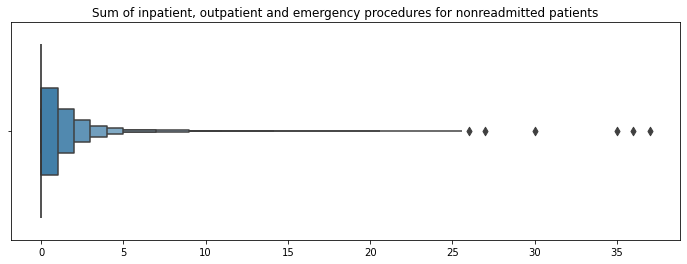

In [31]:
plt.figure(figsize=(12,4))
sns.boxenplot(nonreadmitted_unique_patients['number_inpatient'] 
              + nonreadmitted_unique_patients['number_outpatient'] 
              + nonreadmitted_unique_patients['number_emergency']
              )
plt.title('Sum of inpatient, outpatient and emergency procedures for nonreadmitted patients')
plt.xlabel('Number of procedures')

c:\Users\nicho\miniconda3\envs\361\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Number of procedures')

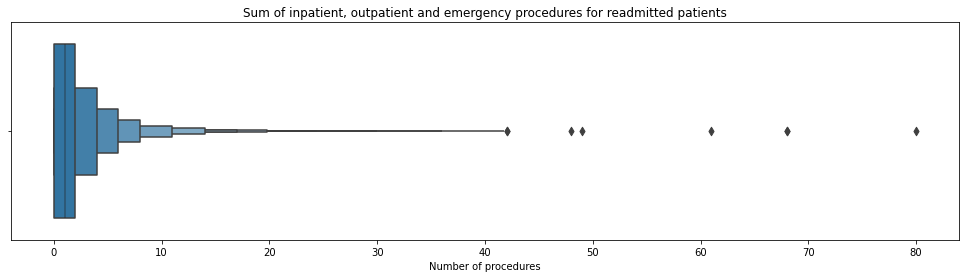

In [32]:
plt.figure(figsize=(17,4))
sns.boxenplot(df[df['patient_nbr'].isin(readmitted_unique_patients['patient_nbr'])]['number_inpatient'] 
              + df[df['patient_nbr'].isin(readmitted_unique_patients['patient_nbr'])]['number_outpatient'] 
              + df[df['patient_nbr'].isin(readmitted_unique_patients['patient_nbr'])]['number_emergency']
              )
plt.title('Sum of inpatient, outpatient and emergency procedures for readmitted patients')
plt.xlabel('Number of procedures')

A handful of patients (in both readmitted and non-readmitted groups) undergo a very large number of procedures, and it would be helpful to know if these are expected or could they have been erroneously recorded.

Two other things to consider regarding data quality (code not shown in this notebook):

1. Some readmitted patients show multiple visits with the final visit classified as NO, while others do not - does this represent an ongoing treatment or a misclassified last visit?

Incorporating knowledge of whether a particular readmission was routine/unavoidable due to the nature of the treatment plan or condition, or if it was unscheduled due to any complications could be valuable for prediction - feature engineering using existing variables could capture some of this information.

Knowing the general proportions of unscheduled readmissions could also inform the choice of algorithm to use - if there are not many, then higher risk patients may be more likely to perform unscheduled readmissions, in which case outlier detection (using isolation forests or DBSCAN) may be useful.

2. Factors such as weight and medical speciality have several values missing (97% and 49%, respectively)

If this data could be acquired from somewhere else, then it may be useful for identifying sub-demographics or geographic regions where high-risk patients are present, which can be targeted for more healthcare resources to reduce readmissions.

# Miscellaneous Questions

In [259]:
# What proportion of patients were on diabetes medication during their hospital stay?
print(nonreadmitted_unique_patients['diabetesMed'].value_counts(normalize=True))
print(readmitted_unique_patients['diabetesMed'].value_counts(normalize=True))

Yes    0.736884
No     0.263116
Name: diabetesMed, dtype: float64
Yes    0.793288
No     0.206712
Name: diabetesMed, dtype: float64


c:\Users\nicho\miniconda3\envs\361\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


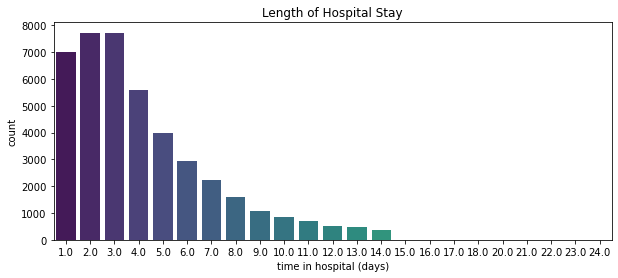

In [129]:
# How long were hospital stays for a given admission?
total_time_in_hospital = df[['patient_nbr', 'time_in_hospital']].groupby('patient_nbr').sum().reset_index()
plt.figure(figsize=(10,4))
sns.countplot(total_time_in_hospital[total_time_in_hospital['patient_nbr'].isin(nonreadmitted_unique_patients['patient_nbr'])]['time_in_hospital'].values, palette='viridis')
plt.xlabel("time in hospital (days)")
plt.title("Length of Hospital Stay")
plt.show()

c:\Users\nicho\miniconda3\envs\361\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


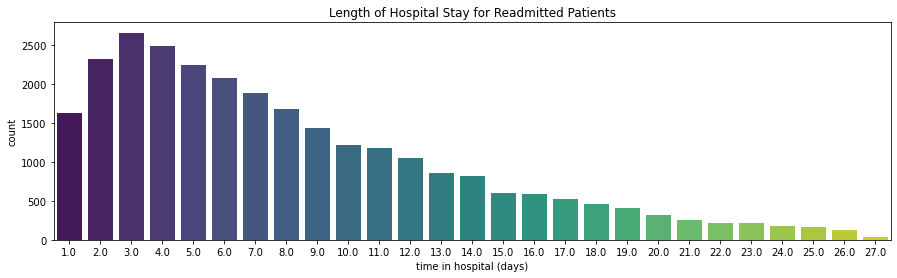

In [137]:
day_count = total_time_in_hospital[total_time_in_hospital['patient_nbr'].isin(readmitted_unique_patients['patient_nbr'])]['time_in_hospital'].values

plt.figure(figsize=(15,4))
sns.countplot(sorted(day_count)[:int(0.96*len(day_count))], palette='viridis')
plt.xlabel("time in hospital (days)")
plt.title("Length of Hospital Stay for Readmitted Patients")
plt.show()